In [ ]:
import numpy as np
import os
import cv2
import shutil
import urllib.request
import scipy.stats as stats
from collections import OrderedDict
from matplotlib import pyplot as plt
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
from torchsummary import summary

## a)  Loading dataset / Preprocessing

In [ ]:
def load_cifar():

    transform = transforms.Compose([transforms.Resize((96,96)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5], std=[0.5])])

    train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=transform)

    #Clear downloading message.
    clear_output()

    # Split dataset into training set and validation set.
    train_dataset, val_dataset = random_split(train_dataset, (45000, 5000))

    print("Image Shape: {}".format(train_dataset[0][0].numpy().shape), end = '\n\n')
    print("Training Set:   {} samples".format(len(train_dataset)))
    print("Validation Set:   {} samples".format(len(val_dataset)))
    print("Test Set:       {} samples".format(len(test_dataset)))

    if torch.cuda.is_available():
        BATCH_SIZE = 1024
    else:
        BATCH_SIZE = 32

    # Create iterator.
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=10000, shuffle=True)

    # Delete the data/ folder.
    shutil.rmtree('./data')

    return train_loader, val_loader, test_loader

In [ ]:
train_loader, val_loader, test_loader = load_cifar()

Image Shape: (3, 96, 96)

Training Set:   45000 samples
Validation Set:   5000 samples
Test Set:       10000 samples


In [ ]:
def plot_example_errors(X, y, y_pred):
    """
        Plots 9 example errors and their associate true/predicted labels.

        Parameters:
        -X: Training examples.
        -y: true labels.
        -y_pred: predicted labels.

    """
    incorrect = (y != y_pred)
    X = X[incorrect]
    y = y[incorrect]
    y_pred = y_pred[incorrect]

    # Plot the first 9 images.
    plot_example(X, y, y_pred)

In [ ]:
def plot_example(X, y, y_pred=None):
    """
        Plots 9 examples and their associate labels.

        Parameters:
        -X: Training examples.
        -y: true labels.
        -y_pred: predicted labels.
    """
    classes = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer',
               5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

    # Create figure with 3 x 3 sub-plots.
    fig, axes = plt.subplots(3, 3, figsize=(10,10))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    X, y = X[:9, 0, ...], y[:9]

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(X[i])

        # Show true and predicted classes.
        if y_pred is None:
            xlabel = "True: {0}".format(classes[y[i]])
        else:
            xlabel = "True: {0}, Pred: {1}".format(classes[y[i]], classes[y_pred[i]])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots in a single Notebook cell.
    plt.show()

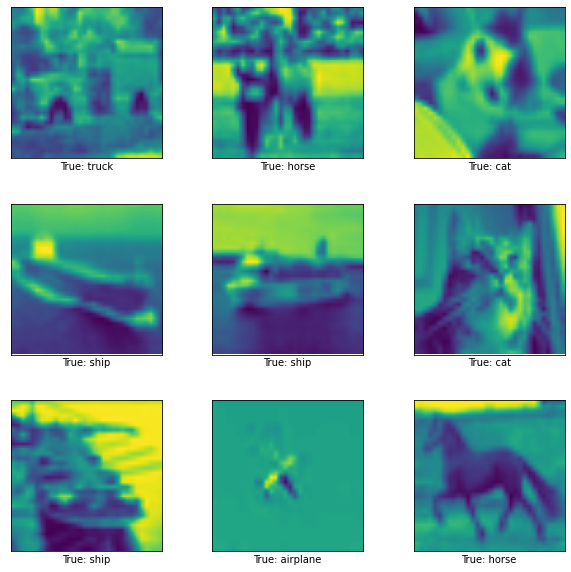

In [ ]:
images, labels = iter(train_loader).next()
plot_example(images.numpy(), labels.numpy())

## b)  Architecture build

In [ ]:
class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvBlock, self).__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

In [ ]:
class InceptionF5(nn.Module):
    """
        From the paper, figure 5 inception module.
    """
    def __init__(self, in_channels):
        super(InceptionF5, self).__init__()

        self.branch1 = nn.Sequential(
            ConvBlock(in_channels, 64, kernel_size=1, stride=1, padding=0),
            ConvBlock(64, 96, kernel_size=3, stride=1, padding=1),
            ConvBlock(96, 96, kernel_size=3, stride=1, padding=1)
        )

        self.branch2 = nn.Sequential(
            ConvBlock(in_channels, 48, kernel_size=1, stride=1, padding=0),
            ConvBlock(48, 64, kernel_size=3, stride=1, padding=1)
        )

        self.branch3 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            ConvBlock(in_channels, 64, kernel_size=1, stride=1, padding=0)
        )

        self.branch4 = nn.Sequential(
            ConvBlock(in_channels, 64, kernel_size=1, stride=1, padding=0)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        return torch.cat([branch1, branch2, branch3, branch4], 1)

In [ ]:
class InceptionF6(nn.Module):
    """
        From the paper, figure 6 inception module.
    """
    def __init__(self, in_channels, f_7x7):
        super(InceptionF6, self).__init__()

        self.branch1 = nn.Sequential(
            ConvBlock(in_channels, f_7x7, kernel_size=1, stride=1, padding=0),
            ConvBlock(f_7x7, f_7x7, kernel_size=(1,7), stride=1, padding=(0,3)),
            ConvBlock(f_7x7, f_7x7, kernel_size=(7,1), stride=1, padding=(3,0)),
            ConvBlock(f_7x7, f_7x7, kernel_size=(1,7), stride=1, padding=(0,3)),
            ConvBlock(f_7x7, 192, kernel_size=(7,1), stride=1, padding=(3,0))
        )

        self.branch2 = nn.Sequential(
            ConvBlock(in_channels, f_7x7, kernel_size=1, stride=1, padding=0),
            ConvBlock(f_7x7, f_7x7, kernel_size=(1,7), stride=1, padding=(0,3)),
            ConvBlock(f_7x7, 192, kernel_size=(7,1), stride=1, padding=(3,0))
        )

        self.branch3 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            ConvBlock(in_channels, 192, kernel_size=1, stride=1, padding=0)
        )

        self.branch4 = nn.Sequential(
            ConvBlock(in_channels, 192, kernel_size=1, stride=1, padding=0)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        return torch.cat([branch1, branch2, branch3, branch4], 1)

In [ ]:
class InceptionF7(nn.Module):
    """
        From the paper, figure 7 inception module.
    """
    def __init__(self, in_channels):
        super(InceptionF7, self).__init__()

        self.branch1 = nn.Sequential(
            ConvBlock(in_channels, 448, kernel_size=1, stride=1, padding=0),
            ConvBlock(448, 384, kernel_size=(3,3), stride=1, padding=1)
        )
        self.branch1_top = ConvBlock(384, 384, kernel_size=(1,3), stride=1, padding=(0,1))
        self.branch1_bot = ConvBlock(384, 384, kernel_size=(3,1), stride=1, padding=(1,0))


        self.branch2 = ConvBlock(in_channels, 384, kernel_size=1, stride=1, padding=0)
        self.branch2_top = ConvBlock(384, 384, kernel_size=(1,3), stride=1, padding=(0,1))
        self.branch2_bot = ConvBlock(384, 384, kernel_size=(3,1), stride=1, padding=(1,0))

        self.branch3 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            ConvBlock(in_channels, 192, kernel_size=1, stride=1, padding=0)
        )

        self.branch4 = nn.Sequential(
            ConvBlock(in_channels, 320, kernel_size=1, stride=1, padding=0)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch1 = torch.cat([self.branch1_top(branch1), self.branch1_bot(branch1)], 1)

        branch2 = self.branch2(x)
        branch2 = torch.cat([self.branch2_top(branch2), self.branch2_bot(branch2)], 1)

        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        return torch.cat([branch1, branch2, branch3, branch4], 1)

In [ ]:
class InceptionRed(nn.Module):
    """
        From the paper, figure 10 improved pooling operation.
    """
    def __init__(self, in_channels, f_3x3_r, add_ch=0):
        super(InceptionRed, self).__init__()

        self.branch1 = nn.Sequential(
            ConvBlock(in_channels, f_3x3_r, kernel_size=1, stride=1, padding=0),
            ConvBlock(f_3x3_r, 178 + add_ch, kernel_size=3, stride=1, padding=1),
            ConvBlock(178 + add_ch, 178 + add_ch, kernel_size=3, stride=2, padding=0)
        )

        self.branch2 = nn.Sequential(
            ConvBlock(in_channels, f_3x3_r, kernel_size=1, stride=1, padding=0),
            ConvBlock(f_3x3_r, 302 + add_ch, kernel_size=3, stride=2, padding=0)
        )

        self.branch3 = nn.Sequential(
            nn.MaxPool2d(3, stride=2, padding=0)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)

        return torch.cat([branch1, branch2, branch3], 1)

In [ ]:
class InceptionAux(nn.Module):
    """
        From the paper, auxilary classifier
    """
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()

        self.pool = nn.AdaptiveAvgPool2d((4,4))
        self.conv = nn.Conv2d(in_channels, 128, kernel_size=1, stride=1, padding=0)
        self.act = nn.ReLU()
        self.fc1 = nn.Linear(2048, 1024)
        self.dropout = nn.Dropout(0.7)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pool(x)

        x = self.conv(x)
        x = self.act(x)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)

        x = self.fc2(x)

        return x

In [ ]:
class InceptionV2(nn.Module):

    def __init__(self, num_classes = 10):
        super(InceptionV2, self).__init__()

        self.conv1 = ConvBlock(3, 32, kernel_size=3, stride=2, padding=0)
        self.conv2 = ConvBlock(32, 32, kernel_size=3, stride=1, padding=0)
        self.conv3 = ConvBlock(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(3, stride=2, padding=0)
        self.conv4 = ConvBlock(64, 80, kernel_size=3, stride=1, padding=0)
        self.conv5 = ConvBlock(80, 192, kernel_size=3, stride=2, padding=0)
        self.conv6 = ConvBlock(192, 288, kernel_size=3, stride=1, padding=1)

        self.inception3a = InceptionF5(288)
        self.inception3b = InceptionF5(288)
        self.inception3c = InceptionF5(288)

        self.inceptionRed1 = InceptionRed(288,f_3x3_r=64, add_ch=0)

        self.inception4a = InceptionF6(768, f_7x7=128)
        self.inception4b = InceptionF6(768, f_7x7=160)
        self.inception4c = InceptionF6(768, f_7x7=160)
        self.inception4d = InceptionF6(768, f_7x7=160)
        self.inception4e = InceptionF6(768, f_7x7=192)

        self.inceptionRed2 = InceptionRed(768,f_3x3_r=192, add_ch=16)

        self.aux = InceptionAux(768, num_classes)

        self.inception5a = InceptionF7(1280)
        self.inception5b = InceptionF7(2048)

        self.pool6 = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool1(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.inception3c(x)

        x = self.inceptionRed1(x)

        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)

        aux = self.aux(x)

        x = self.inceptionRed2(x)
        x = self.inception5a(x)
        x = self.inception5b(x)

        x = self.pool6(x)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x, aux

In [ ]:
model = InceptionV2()

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
summary(model, (3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 47, 47]             896
       BatchNorm2d-2           [-1, 32, 47, 47]              64
              ReLU-3           [-1, 32, 47, 47]               0
         ConvBlock-4           [-1, 32, 47, 47]               0
            Conv2d-5           [-1, 32, 45, 45]           9,248
       BatchNorm2d-6           [-1, 32, 45, 45]              64
              ReLU-7           [-1, 32, 45, 45]               0
         ConvBlock-8           [-1, 32, 45, 45]               0
            Conv2d-9           [-1, 64, 45, 45]          18,496
      BatchNorm2d-10           [-1, 64, 45, 45]             128
             ReLU-11           [-1, 64, 45, 45]               0
        ConvBlock-12           [-1, 64, 45, 45]               0
        MaxPool2d-13           [-1, 64, 22, 22]               0
           Conv2d-14           [-1, 80,

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## c) Training the model

In [ ]:
def train_model():
    EPOCHS = 15
    nb_examples = 45000
    nb_val_examples = 5000
    train_costs, val_costs = [], []

    #Training phase.

    for epoch in range(EPOCHS):

        train_loss = 0
        correct_train = 0

        model.train().cuda()

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # Zero the parameter gradients.
            optimizer.zero_grad()

            # Forward pass.
            prediction0, prediction1 = model(inputs)

            # Compute the loss.
            loss0 = criterion(prediction0, labels)
            loss1 = criterion(prediction1, labels)

            loss = loss0 + 0.3 * loss1
            # Backward pass.
            loss.backward()

            # Optimize.
            optimizer.step()

            # Compute training accuracy.
            _, predicted = torch.max(prediction0.data, 1)
            correct_train += (predicted == labels).float().sum().item()

            # Compute batch loss.
            train_loss += (loss.data.item() * inputs.shape[0])


        train_loss /= nb_examples
        train_costs.append(train_loss)
        train_acc =  correct_train / nb_examples

        val_loss = 0
        correct_val = 0

        model.eval().cuda()

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass.
                prediction0, prediction1 = model(inputs)

                # Compute the loss.
                loss0 = criterion(prediction0, labels)
                loss1 = criterion(prediction1, labels)

                loss = loss0 + 0.3 * loss1

                # Compute training accuracy.
                _, predicted = torch.max(prediction0.data, 1)
                correct_val += (predicted == labels).float().sum().item()

            # Compute batch loss.
            val_loss += (loss.data.item() * inputs.shape[0])

            val_loss /= nb_val_examples
            val_costs.append(val_loss)
            val_acc =  correct_val / nb_val_examples

        info = "[Epoch {}/{}]: train-loss = {:0.6f} | train-acc = {:0.3f} | val-loss = {:0.6f} | val-acc = {:0.3f}"
        print(info.format(epoch+1, EPOCHS, train_loss, train_acc, val_loss, val_acc))
        torch.save(model.state_dict(), 'save_weights/checkpoint_gpu_{}'.format(epoch + 1))

    torch.save(model.state_dict(), 'save_weights/inception-v2_weights_gpu')

    return train_costs, val_costs

In [ ]:
train_costs, val_costs = train_model()

[Epoch 1/15]: train-loss = 2.559885 | train-acc = 0.259 | val-loss = 2.215568 | val-acc = 0.359
[Epoch 2/15]: train-loss = 1.992639 | train-acc = 0.424 | val-loss = 1.846719 | val-acc = 0.472
[Epoch 3/15]: train-loss = 1.640984 | train-acc = 0.537 | val-loss = 1.591195 | val-acc = 0.558
[Epoch 4/15]: train-loss = 1.385598 | train-acc = 0.619 | val-loss = 1.439533 | val-acc = 0.614
[Epoch 5/15]: train-loss = 1.168221 | train-acc = 0.684 | val-loss = 1.305238 | val-acc = 0.655
[Epoch 6/15]: train-loss = 1.002453 | train-acc = 0.731 | val-loss = 1.214881 | val-acc = 0.681
[Epoch 7/15]: train-loss = 0.851118 | train-acc = 0.771 | val-loss = 1.217857 | val-acc = 0.687
[Epoch 8/15]: train-loss = 0.711145 | train-acc = 0.811 | val-loss = 1.147356 | val-acc = 0.711
[Epoch 9/15]: train-loss = 0.608349 | train-acc = 0.838 | val-loss = 1.140132 | val-acc = 0.724
[Epoch 10/15]: train-loss = 0.515004 | train-acc = 0.863 | val-loss = 1.154486 | val-acc = 0.735
[Epoch 11/15]: train-loss = 0.437409 | 

In [ ]:
#Restore the model.
model = InceptionV2()
model.load_state_dict(torch.load('save_weights/inception-v2_weights_gpu'))

<All keys matched successfully>

In [ ]:
nb_test_examples = 10000
correct = 0

model.eval().cuda()

with  torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # Make predictions.
        prediction, _ = model(inputs)

        # Retrieve predictions indexes.
        _, predicted_class = torch.max(prediction.data, 1)

        # Compute number of correct predictions.
        correct += (predicted_class == labels).float().sum().item()

test_accuracy = correct / nb_test_examples
print('Test accuracy: {}'.format(test_accuracy))

Test accuracy: 0.7418
